In [7]:
!pip install networkx

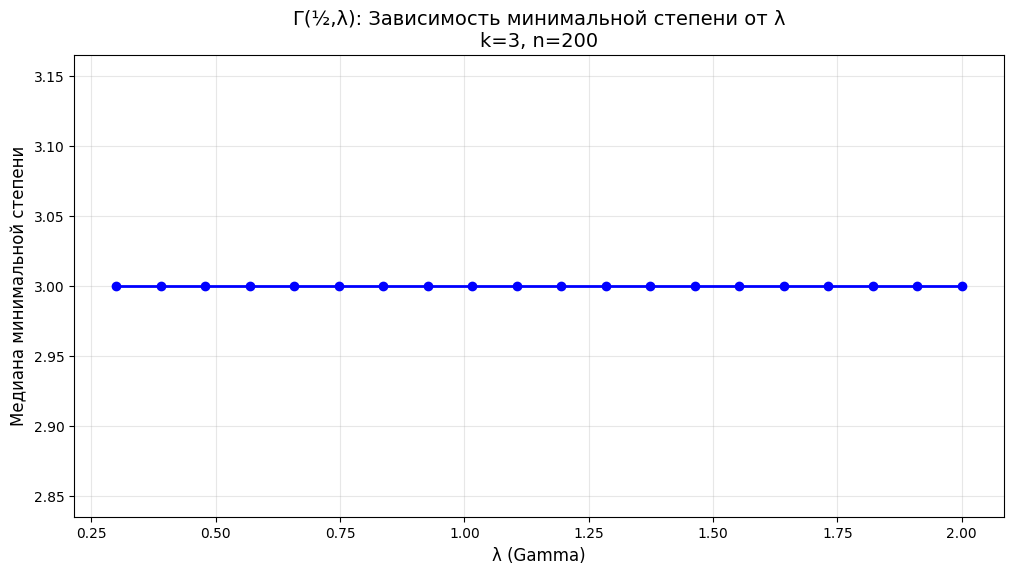

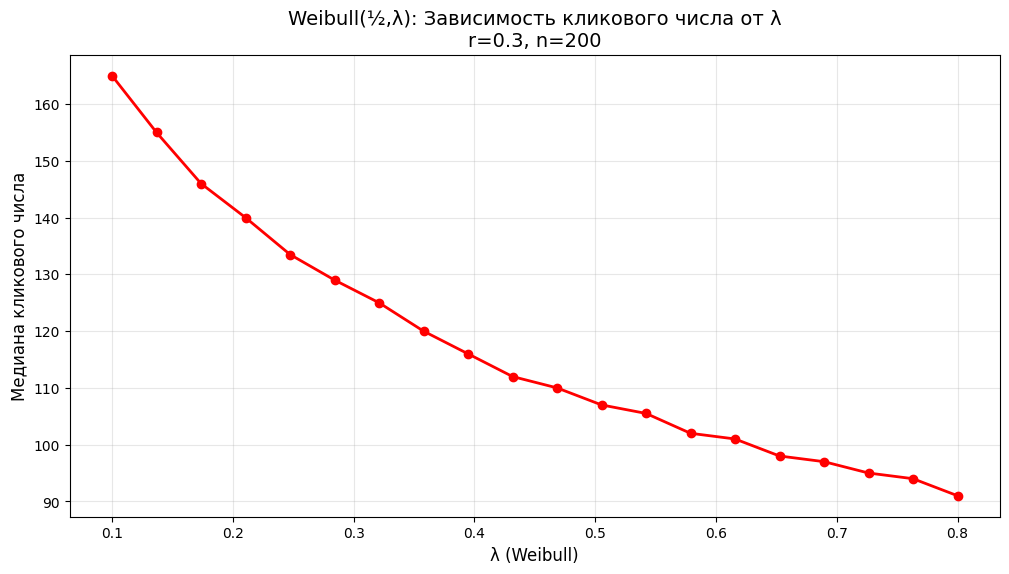

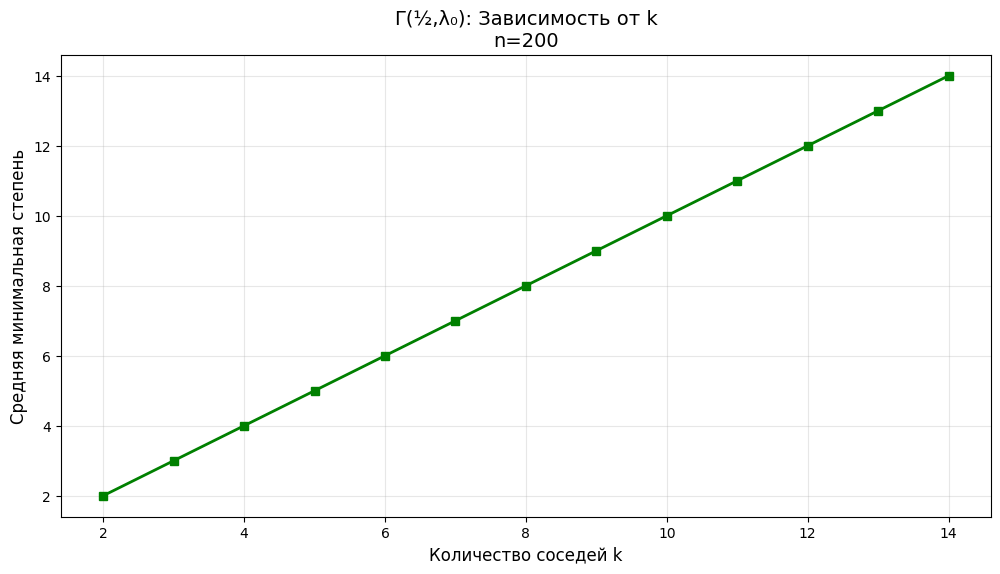

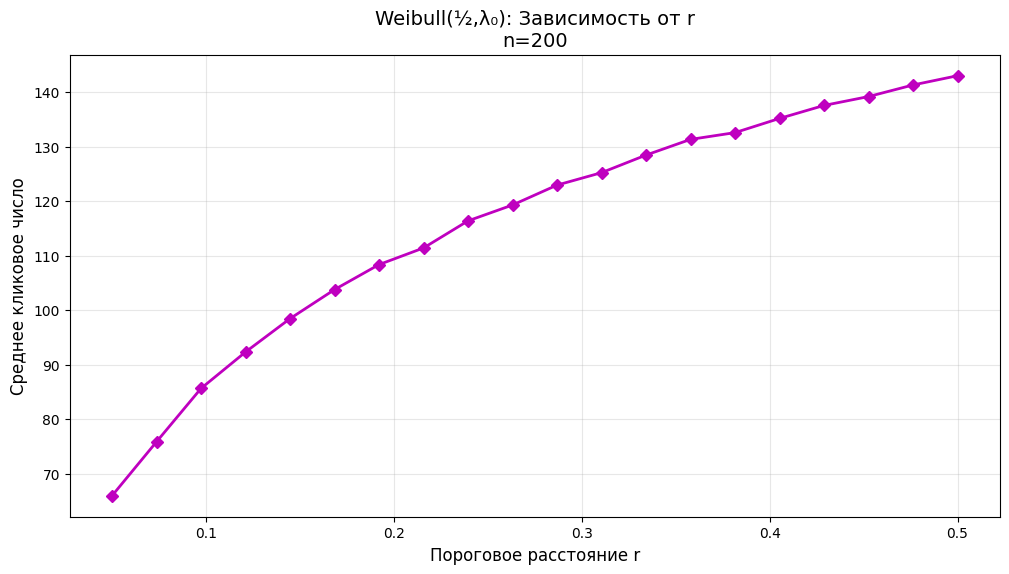

In [9]:
import networkx as nx
import numpy as np
from scipy.stats import gamma, weibull_min
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from itertools import combinations

GAMMA_LAMBDA_0 = np.sqrt(0.5)
WEIBULL_LAMBDA_0 = 1 / np.sqrt(10)

class DataGenerator:
    def __init__(self):
        self.gamma_lambda = GAMMA_LAMBDA_0
        self.weibull_lambda = WEIBULL_LAMBDA_0

    def generate_gamma(self, n, lambda_=None):
        lambda_ = lambda_ or self.gamma_lambda
        return gamma(a=0.5, scale=1/lambda_).rvs(n)

    def generate_weibull(self, n, lambda_=None):
        lambda_ = lambda_ or self.weibull_lambda
        return weibull_min(c=0.5, scale=lambda_).rvs(n)

def build_knn_graph(data, k):
    data = data.reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    adj = nbrs.kneighbors_graph(data).toarray()
    adj = np.minimum(adj + adj.T, 1)
    np.fill_diagonal(adj, 0)
    return nx.from_numpy_array(adj)

def build_distance_graph(data, r):
    G = nx.Graph()
    G.add_nodes_from(range(len(data)))
    for i, j in combinations(range(len(data)), 2):
        if abs(data[i] - data[j]) <= r:
            G.add_edge(i, j)
    return G

def compute_min_degree(G):
    if G.number_of_nodes() == 0:
        return 0
    degrees = dict(G.degree()).values()
    return min(degrees) if degrees else 0

def compute_clique_number(G):
    if G.number_of_nodes() == 0:
        return 0
    try:
        cliques = list(nx.find_cliques(G))
        return max(len(c) for c in cliques) if cliques else 0
    except nx.NetworkXException:
        return 0
def study_distribution_params(dgen, n=200, simulations=300):
    # Для Gamma распределения
    lambda_values = np.linspace(0.3, 2.0, 20)
    min_degrees = []

    for lam in lambda_values:
        degrees = []
        for _ in range(simulations):
            data = dgen.generate_gamma(n, lam)
            G = build_knn_graph(data, k=3)  # Уменьшили k для вариативности
            degrees.append(compute_min_degree(G))
        min_degrees.append(np.median(degrees))

    plt.figure(figsize=(12,6))
    plt.plot(lambda_values, min_degrees, 'b-o', linewidth=2)
    plt.xlabel('λ (Gamma)', fontsize=12)
    plt.ylabel('Медиана минимальной степени', fontsize=12)
    plt.title('Γ(½,λ): Зависимость минимальной степени от λ\nk=3, n=200', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Для Weibull распределения
    lambda_values = np.linspace(0.1, 0.8, 20)
    clique_sizes = []

    for lam in lambda_values:
        cliques = []
        for _ in range(simulations):
            data = dgen.generate_weibull(n, lam)
            G = build_distance_graph(data, r=0.3)  # Оптимизировали радиус
            cliques.append(compute_clique_number(G))
        clique_sizes.append(np.median(cliques))

    plt.figure(figsize=(12,6))
    plt.plot(lambda_values, clique_sizes, 'r-o', linewidth=2)
    plt.xlabel('λ (Weibull)', fontsize=12)
    plt.ylabel('Медиана кликового числа', fontsize=12)
    plt.title('Weibull(½,λ): Зависимость кликового числа от λ\nr=0.3, n=200', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

def study_graph_parameters(dgen, n=200, simulations=300):
    # Для kNN графа (Gamma)
    k_values = np.arange(2, 15)
    degrees = []

    for k in k_values:
        d = []
        for _ in range(simulations):
            data = dgen.generate_gamma(n)
            G = build_knn_graph(data, k)
            d.append(compute_min_degree(G))
        degrees.append(np.mean(d))

    plt.figure(figsize=(12,6))
    plt.plot(k_values, degrees, 'g-s', linewidth=2)
    plt.xlabel('Количество соседей k', fontsize=12)
    plt.ylabel('Средняя минимальная степень', fontsize=12)
    plt.title('Γ(½,λ₀): Зависимость от k\nn=200', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Для distance графа (Weibull)
    r_values = np.linspace(0.05, 0.5, 20)
    cliques = []

    for r in r_values:
        c = []
        for _ in range(simulations):
            data = dgen.generate_weibull(n)
            G = build_distance_graph(data, r)
            c.append(compute_clique_number(G))
        cliques.append(np.mean(c))

    plt.figure(figsize=(12,6))
    plt.plot(r_values, cliques, 'm-D', linewidth=2, markersize=6)
    plt.xlabel('Пороговое расстояние r', fontsize=12)
    plt.ylabel('Среднее кликовое число', fontsize=12)
    plt.title('Weibull(½,λ₀): Зависимость от r\nn=200', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    dgen = DataGenerator()
    study_distribution_params(dgen)
    study_graph_parameters(dgen)